In [1]:
from phonopy.units import VaspToTHz
from ase.build import bulk
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_13515/1475336949.py:1: DeprecationWarning: phonopy.units.* is deprecated. Use phonopy.physical_units.physical_units instead.
  from phonopy.units import VaspToTHz


# Objective:

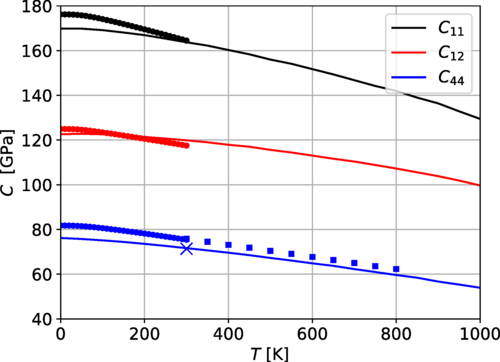

# QHA (Temperature Dependent Lattice Constant): 

## Functions:

**Limitation on t_max over 930 or does the system melt?**

In [2]:
def get_temperatures_and_volumes(structure: "ase.atoms.Atoms", 
                                 potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1", 
                                 t_min: float = 0, t_max: float = 900, t_step: float = 10) -> float:
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )

    from atomistics.workflows import (
    get_tasks_for_quasi_harmonic_approximation,
    analyse_results_for_quasi_harmonic_approximation,
    get_thermal_properties_for_quasi_harmonic_approximation,
    )
    
    potential_dataframe = get_potential_by_name(potential_name)
    task_dict, qh_dict = get_tasks_for_quasi_harmonic_approximation(
        structure=bulk_st,
        num_points=11,
        vol_range=0.05,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
    )
    
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe = potential_dataframe
    )
    
    eng_internal_dict, phonopy_collect_dict = analyse_results_for_quasi_harmonic_approximation(
        qh_dict=qh_dict,
        output_dict=result_dict,
        dos_mesh=20,
        number_of_snapshots=None,
    )
    
    term_qh_dict = get_thermal_properties_for_quasi_harmonic_approximation(
        eng_internal_dict = eng_internal_dict,
        task_dict = task_dict,
        qh_dict = qh_dict,
        fit_type = "polynomial",
        fit_order = 3,
        t_min = t_min,
        t_max = t_max,
        t_step = t_step,
        temperatures = None,
        cutoff_frequency = None,
        pretend_real = False,
        band_indices = None,
        is_projection = False,
        quantum_mechanical = True,
    )
        
    return {'temperatures': term_qh_dict['temperatures'], 'volumes': term_qh_dict['volumes']}

In [3]:
def get_lattice_const_from_fitting(temperature: float, 
                               fitted_temperatures: list[float],
                               fitted_volumes: list[float],
                               length_scale: float = 100.0):
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF

    # temperatures = np.array(temperatures)
    # --- Define kernel with constant kernel ---
    kernel = RBF(length_scale=length_scale)

    # Change this to a  list of temperatures and volumes
    X = np.reshape(fitted_temperatures,(-1, 1))
    y = fitted_volumes
    
    # --- Fit GP ---
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(X, y)

    if temperature > fitted_temperatures.max() or temperature < fitted_temperatures.min():
        print(f"Chosen temperature value of {temperature} is not in the range of {fitted_temperatures.min()} to {fitted_temperatures.max()}")
    lattice_constant = gp.predict(np.reshape(temperature, (-1, 1)))**(1/3)
    
    return lattice_constant
    

In [4]:
def get_lattice_const_qha(structure: "ase.atoms.Atoms", 
                          potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1", 
                          temperature: float = 300) -> float:
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )

    from atomistics.workflows import (
        get_tasks_for_quasi_harmonic_approximation,
        analyse_results_for_quasi_harmonic_approximation,
        get_thermal_properties_for_quasi_harmonic_approximation,
    )
    
    potential_dataframe = get_potential_by_name(potential_name)
    task_dict, qh_dict = get_tasks_for_quasi_harmonic_approximation(
        structure=bulk_st,
        num_points=11,
        vol_range=0.05,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
    )
    
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe = potential_dataframe
    )
    
    eng_internal_dict, phonopy_collect_dict = analyse_results_for_quasi_harmonic_approximation(
        qh_dict=qh_dict,
        output_dict=result_dict,
        dos_mesh=20,
        number_of_snapshots=None,
    )
    
    term_qh_dict = get_thermal_properties_for_quasi_harmonic_approximation(
        eng_internal_dict=eng_internal_dict,
        task_dict=task_dict,
        qh_dict=qh_dict,
        fit_type="polynomial",
        fit_order=3,
        t_min=temperature,
        t_max=temperature,
        t_step=0,
        temperatures=None,
        cutoff_frequency=None,
        pretend_real=False,
        band_indices=None,
        is_projection=False,
        quantum_mechanical=True,
    )
    
    lattice_constant = term_qh_dict['volumes'][-1]**(1/3)
    
    return lattice_constant

## Workflow:

In [5]:
bulk_st = bulk("Cu", cubic= True)
potential_name = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1" 
temperature = 850

In [6]:
lattice_constant = get_lattice_const_qha(structure = bulk_st, potential_name= potential_name, temperature=temperature)

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-11-03/lib/python3.12/site-packages/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


In [7]:
lattice_constant

np.float64(3.66366135133358)

In [8]:
temp_vol_dict = get_temperatures_and_volumes(structure = bulk_st, potential_name = potential_name)

In [9]:
lattice_constant = get_lattice_const_from_fitting(temperature=temperature, 
                                                  fitted_temperatures=temp_vol_dict['temperatures'], 
                                                  fitted_volumes = temp_vol_dict['volumes'])

In [10]:
lattice_constant

array([3.66366075])

# 0K Elastic Constants (from potential energy) [OPTIONAL]:

## Functions:

In [11]:
def get_elastic_const_pot_eng(structure: "ase.atoms.Atoms", 
                          eps_range : float = 0.005, 
                          potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"):
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )
    from atomistics.workflows import optimize_positions_and_volume
    from atomistics.workflows.elastic.helper import get_tasks_for_elastic_matrix, analyse_results_for_elastic_matrix

    potential_dataframe = get_potential_by_name(potential_name)
    # obtain relaxed structure
    task_dict = optimize_positions_and_volume(structure=structure)
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_dataframe,
    )
    structure_opt = result_dict["structure_with_optimized_positions_and_volume"]

    # Generate structures for elastic matrix
    task_dict, sym_dict= get_tasks_for_elastic_matrix(
        structure=structure_opt,
        eps_range = eps_range,  
        num_of_point = 3,
        sqrt_eta=True
    )
    # Evaluate with lammps to get the energies
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_dataframe,
    )

    # Obtain the elastic matrix
    # only meaningful values are C11, C12, C44 for cubic metals in 'elastic_matrix'
    fit_dict, sym_dict = analyse_results_for_elastic_matrix(output_dict = result_dict, sym_dict=sym_dict)

    return {
        'C11': fit_dict['elastic_matrix'][0,0],
        'C12': fit_dict['elastic_matrix'][0,1],
        'C44': fit_dict['elastic_matrix'][3,3]}

## Workflow:

In [12]:
bulk_st = bulk("Cu", cubic= True)
potential_name = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1" 

In [13]:
elastic_constants = get_elastic_const_pot_eng(structure = bulk_st)

In [14]:
elastic_constants

{'C11': np.float64(169.75217354590148),
 'C12': np.float64(123.48780038429686),
 'C44': np.float64(76.24337810079075)}

# Temperature Dependent Elastic Constants:

## Functions:

In [15]:
def get_free_energies(strained_structures: dict, temperature: float, potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1") -> dict:
    
    from atomistics.workflows import (
        get_tasks_for_harmonic_approximation, 
        analyse_results_for_harmonic_approximation, 
        get_thermal_properties_for_harmonic_approximation,
    )
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )

    potential_dataframe = get_potential_by_name(potential_name)
    free_energies_dict = {}
    for key, st in strained_structures['calc_energy'].items():
        task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
            structure=st,
            interaction_range=10,
            factor=VaspToTHz,
            displacement=0.01,
            primitive_matrix=None,
            number_of_snapshots=None,
        )
        
        lammps_evaluation = evaluate_with_lammpslib(
            task_dict=task_dict,
            potential_dataframe=potential_dataframe,
        )
        
        phonopy_dict = analyse_results_for_harmonic_approximation(
            phonopy=phonopy_obj,
            output_dict=lammps_evaluation,
            dos_mesh=20,
            number_of_snapshots=None,
        )
        
        term_base_dict = get_thermal_properties_for_harmonic_approximation(
            phonopy=phonopy_obj,
            t_min=temperature,
            t_max=temperature,
            t_step=1,
            temperatures=None,
            cutoff_frequency=None,
            pretend_real=False,
            band_indices=None,
            is_projection=False,
        )
        free_energies_dict[key] = term_base_dict['free_energy'][-1]
        
    return free_energies_dict

In [16]:
def fix_free_energies(pot_energy_dict: dict, free_energy_dict: dict):
    
    corrected_results_dict = {'energy':None}
    fixed_free_energies = {}
    for key, en in pot_energy_dict['energy'].items():
        fixed_free_energies[key] = free_energy_dict[key] + en
    
    corrected_results_dict['energy']= fixed_free_energies
    
    return corrected_results_dict

In [17]:
def get_elastic_constants_for_temperatures(structure: "ase.atoms.Atoms",
                                           temperatures_list: list,
                                           potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1",
                                           eps_range: float = 0.005
                                           ) -> dict:
    
    from atomistics.workflows.elastic.helper import get_tasks_for_elastic_matrix, analyse_results_for_elastic_matrix
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )
    
    elastic_constants_dict = {
        'temperatures': temperatures_list,
        'C11': [], 
        'C12': [], 
        'C44': []
    }
    potential_dataframe = get_potential_by_name(potential_name)
    for temperature in temperatures_list:
        print(f"Obtaining elastic constants at {temperature}K.")
        
        # Get temperature dependent lattice constant
        a = get_lattice_const_qha(structure = structure, potential_name = potential_name, temperature = temperature)
        element = bulk_st.get_chemical_symbols()[0]
        structure_temp = bulk(element, cubic= True, a = a)

        # Generate strained structures for elastic matrix
        gen_strain_structures, sym_dict= get_tasks_for_elastic_matrix(
            structure=structure_temp,
            eps_range = eps_range,
            num_of_point = 5, # 3 or 5
            sqrt_eta=True
        )

        # Calculate potential energy for strained structures
        pot_energy_dict = evaluate_with_lammpslib(
        task_dict=gen_strain_structures,
        potential_dataframe=potential_dataframe,
        )

        # Calculate free energy for strained structures and add the potential energy for each strained structure 
        # to get the corrected free energy
        free_energy_dict = get_free_energies(strained_structures=gen_strain_structures, temperature = temperature, potential_name = potential_name)
        corrected_results_dict = fix_free_energies(pot_energy_dict= pot_energy_dict, free_energy_dict= free_energy_dict) 

        # Get elastic constants
        fit_corrected_dict, sym_dict = analyse_results_for_elastic_matrix(output_dict = corrected_results_dict, sym_dict=sym_dict)
        
        elastic_constants_dict['C11'].append(fit_corrected_dict['elastic_matrix'][0,0])
        elastic_constants_dict['C12'].append(fit_corrected_dict['elastic_matrix'][0,1])
        elastic_constants_dict['C44'].append(fit_corrected_dict['elastic_matrix'][3,3])
        
    return elastic_constants_dict

## Workflow:

In [18]:
temperatures_list = np.linspace(start = 0, stop = 900, num = 10)

In [19]:
bulk_st = bulk("Cu", cubic= True)
potential_name = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1" 

In [20]:
elastic_constants_dict = get_elastic_constants_for_temperatures(
    structure= bulk_st, 
    temperatures_list= temperatures_list)

Obtaining elastic constants at 0.0K.
Obtaining elastic constants at 100.0K.
Obtaining elastic constants at 200.0K.
Obtaining elastic constants at 300.0K.
Obtaining elastic constants at 400.0K.
Obtaining elastic constants at 500.0K.
Obtaining elastic constants at 600.0K.
Obtaining elastic constants at 700.0K.
Obtaining elastic constants at 800.0K.
Obtaining elastic constants at 900.0K.


In [21]:
txt = np.loadtxt("C11_data.txt")

In [22]:
temp_c11_exp = txt[:,0]

In [23]:
c11_exp = txt[:, 1]

In [24]:
txt = np.loadtxt("C12_data.txt")

In [25]:
temp_c12_exp = txt[:,0]

In [26]:
c12_exp = txt[:, 1]

In [27]:
txt = np.loadtxt("C44_data.txt")

In [28]:
temp_c44_exp = txt[:,0]

In [29]:
c44_exp = txt[:, 1]

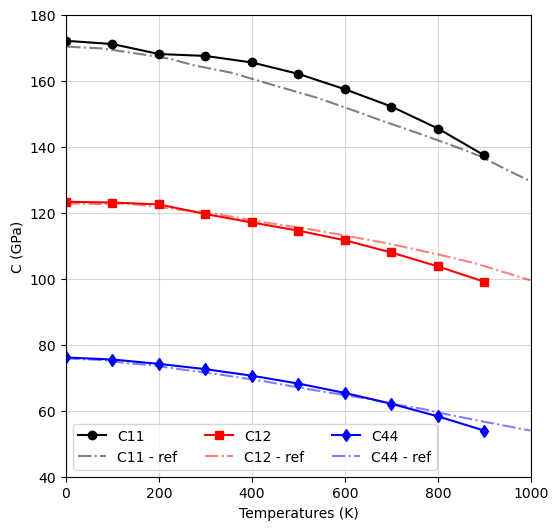

In [30]:
fix, ax = plt.subplots( figsize = (6, 6))

ax.plot(elastic_constants_dict['temperatures'], elastic_constants_dict['C11'], color = 'k', label = 'C11', marker = 'o')
ax.plot(temp_c11_exp, c11_exp, color = 'k', alpha = 0.5, ls = '-.', label = "C11 - ref")

ax.plot(elastic_constants_dict['temperatures'], elastic_constants_dict['C12'], color = 'red', label = 'C12', marker = 's')
ax.plot(temp_c12_exp, c12_exp, color = 'red', alpha = 0.5, ls = '-.', label = "C12 - ref")

ax.plot(elastic_constants_dict['temperatures'], elastic_constants_dict['C44'], color = 'blue', label = 'C44', marker = 'd')
ax.plot(temp_c44_exp, c44_exp, color = 'blue', alpha = 0.5, ls = '-.', label = "C44 - ref")

ax.set_xlabel("Temperatures (K)")
ax.set_ylabel("C (GPa)")
ax.legend(ncols = 3)
ax.set_yticks(range(40,190,20))
ax.set_xlim([0, 1000])
ax.grid(alpha= 0.5);

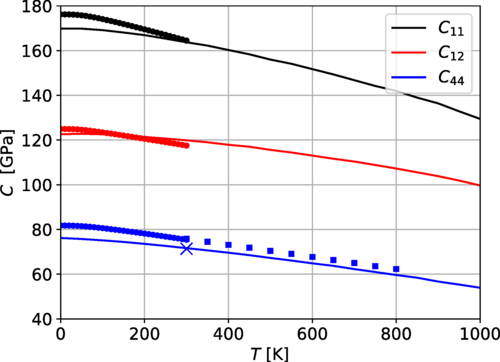

# Manually Calculate Free Energies:

## Functions:

Quantum free energy per mode:

$F_{quantum}​=(1/2)*​ℏω + kB​T * ln(1−e^{−ℏω/kB​T})$

$F_{\text{quantum}} = E_0 + \sum_i \left[ \frac{1}{2}\hbar \omega_i + k_B T \ln\left( 1 - e^{-\hbar \omega_i / k_B T} \right) \right]$


In [ ]:
from pint import UnitRegistry

In [ ]:
ureg = UnitRegistry()

In [ ]:
f_quan = (0.5) * ureg.planck_constant*

In [ ]:
def get_quantum_free_energy(structure: "ase.atoms.Atoms", temperature : float, potential_name: str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1") -> dict:
    
    from atomistics.workflows import (
        get_tasks_for_harmonic_approximation, 
        analyse_results_for_harmonic_approximation, 
        get_thermal_properties_for_harmonic_approximation,
    )
    
    from atomistics.calculators import (
        evaluate_with_lammpslib,
        get_potential_by_name,
    )

    potential_dataframe = get_potential_by_name(potential_name)  
    
    task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
        structure=structure,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
        primitive_matrix=None,
        number_of_snapshots=None,
    )
    
    lammps_evaluation = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_dataframe,
    )
    
    phonopy_dict = analyse_results_for_harmonic_approximation(
        phonopy=phonopy_obj,
        output_dict=lammps_evaluation,
        dos_mesh=20,
        number_of_snapshots=None,
    )
    
    term_base_dict = get_thermal_properties_for_harmonic_approximation(
        phonopy=phonopy_obj,
        t_min=temperature,
        t_max=temperature,
        t_step=1,
        temperatures=None,
        cutoff_frequency=None,
        pretend_real=False,
        band_indices=None,
        is_projection=False,
    )
    return term_base_dict

## Workflow:

In [ ]:
free_dict = get_quantum_free_energy(bulk_st)

In [ ]:
free_dict